<a href="https://colab.research.google.com/github/IlyaZutler/GBR-agents/blob/main/GBR_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
!pip install simpy
import simpy
import random
import time


In [10]:
class Agent:
    def __init__(self, env, location, speed):
        self.env = env # Ссылка на объект окружения симуляции
        self.location = location
        self.speed = speed
        self.state = 'free'
        self.alarm = None
        self.start_time = None
        self.busy_time = 0

    def travel_time(self, target):
        return abs(self.location - target) / self.speed

    def handle_alarm(self, alarm):
        self.state = 'busy'
        self.alarm = alarm
        self.start_time = self.env.now

        # Время на дорогу до тревоги
        travel_to_alarm = self.travel_time(alarm.location)
        yield self.env.timeout(travel_to_alarm)

        # Время на обработку тревоги
        alarm.arrival_time = self.env.now
        yield self.env.timeout(alarm.complexity)

        # Агенты остаются занятыми до завершения обработки тревоги
        self.busy_time += self.env.now - self.start_time
        self.state = 'free'
        self.alarm = None

        # Время на возвращение к месту дислокации
        yield self.env.timeout(travel_to_alarm)

class Alarm:
    def __init__(self, location, complexity):
        self.location = location
        self.complexity = complexity
        self.arrival_time = None


In [11]:
class Simulation:
    def __init__(self, num_agents, segment_length, agent_speed, alarm_rate, complexity_mean, complexity_sigma, threshold):
        self.env = simpy.Environment()
        # Равномерное распределение агентов вдоль отрезка
        self.agents = [Agent(self.env, i * segment_length / (num_agents - 1), agent_speed) for i in range(num_agents)]

        self.segment_length = segment_length
        self.alarm_rate = alarm_rate
        self.complexity_mean = complexity_mean
        self.complexity_sigma = complexity_sigma
        self.threshold = threshold
        self.alarms = []
        self.total_alarms = 0
        self.total_response_time = 0
        self.delayed_alarms = 0

    def generate_alarms(self):
        while True:
            yield self.env.timeout(random.expovariate(self.alarm_rate))
            location = random.uniform(0, self.segment_length)
            complexity = np.random.lognormal(self.complexity_mean, self.complexity_sigma)
            alarm = Alarm(location, complexity)
            self.alarms.append(alarm)
            self.total_alarms += 1
            self.env.process(self.dispatch_agent(alarm))

    # def dispatch_agent(self, alarm):
    #     available_agents = [agent for agent in self.agents if agent.state == 'free']
    #     if available_agents:
    #         closest_agent = min(available_agents, key=lambda agent: agent.travel_time(alarm.location))
    #         closest_agent.start_time = self.env.now
    #         self.total_response_time += closest_agent.travel_time(alarm.location)
    #         if closest_agent.travel_time(alarm.location) > self.threshold:
    #             self.delayed_alarms += 1
    #         self.env.process(closest_agent.handle_alarm(alarm))

    def dispatch_agent(self, alarm):
        available_agents = [agent for agent in self.agents if agent.state == 'free']
        if available_agents:
            closest_agent = min(available_agents, key=lambda agent: agent.travel_time(alarm.location))
            closest_agent.start_time = self.env.now
            self.total_response_time += closest_agent.travel_time(alarm.location)
            if closest_agent.travel_time(alarm.location) > self.threshold:
                self.delayed_alarms += 1
            yield self.env.process(closest_agent.handle_alarm(alarm)) # Yield the process here


    def run(self, duration):
        self.env.process(self.generate_alarms())
        self.env.run(until=duration)

    def report(self):
        print(f"Total Alarms: {self.total_alarms}")
        print(f"Average Response Time: {self.total_response_time / self.total_alarms if self.total_alarms else 0}")
        print(f"Fraction of Delayed Alarms: {self.delayed_alarms / self.total_alarms if self.total_alarms else 0}")
        for i, agent in enumerate(self.agents):
            print(f"Agent {i} Busy Time Fraction: {agent.busy_time / self.env.now if self.env.now else 0}")


Total Alarms: 5
Average Response Time: 310.3055082638302
Fraction of Delayed Alarms: 1.0
Agent 0 Busy Time Fraction: 0.0
Agent 1 Busy Time Fraction: 0.0
Agent 2 Busy Time Fraction: 0.0
Agent 3 Busy Time Fraction: 0.0
Agent 4 Busy Time Fraction: 0.0


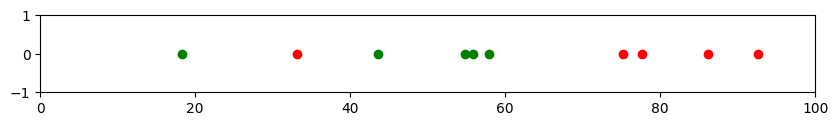

KeyboardInterrupt: 

In [12]:
def visualize(simulation, interval=1):
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.set_xlim(0, simulation.segment_length)
    ax.set_ylim(-1, 1)

    while simulation.env.peek() < float('inf'):
        ax.clear()
        ax.set_xlim(0, simulation.segment_length)
        ax.set_ylim(-1, 1)

        for agent in simulation.agents:
            if agent.state == 'free':
                ax.plot(agent.location, 0, 'bo')
            elif agent.state == 'busy':
                ax.plot(agent.location, 0, 'go')

        for alarm in simulation.alarms:
            if alarm.arrival_time is None:
                ax.plot(alarm.location, 0, 'ro')
            else:
                ax.plot(alarm.location, 0, 'mo')

        plt.pause(interval)
        simulation.env.step()

    plt.show()

# Параметры моделирования
num_agents = 5
segment_length = 100
agent_speed = 0.1
alarm_rate = 0.1
complexity_mean = 1
complexity_sigma = 0.5
threshold = 10

# Создание и запуск симуляции
sim = Simulation(num_agents, segment_length, agent_speed, alarm_rate, complexity_mean, complexity_sigma, threshold)
sim.run(duration=100)

# Отчёт о результатах
sim.report()

# Визуализация процесса
visualize(sim, interval=0.1)
